# Reading, inspecting, cleaning up, saving tabular data

I want to create ensembles of decision trees. It's of two key techniques in machine learning (the other being neural networks with stochastic gradient descent).

In [14]:
# First, let's find a dataset of tabular data.
# I'll choose the titanic dataset from kaggle.
import pathlib
import fastbook
import kaggle
import shutil

def get_kaggle_dataset(comp):
    kaggle_api_credentials = pathlib.Path('~/.kaggle/kaggle.json').expanduser().read_text()
    path = fastbook.URLs.path(comp)
    if path.exists():
        print(path, "already exists.")
        return path
    path.mkdir(parents=True)
    kaggle.api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))
    return path
    
print(get_kaggle_dataset("titanic"))


100%|██████████| 34.1k/34.1k [00:00<00:00, 68.1MB/s]


/home/john/.fastai/archive/titanic


In [16]:
path = get_kaggle_dataset("titanic")
print(path.ls())

/home/john/.fastai/archive/titanic already exists.
[Path('/home/john/.fastai/archive/titanic/gender_submission.csv'), Path('/home/john/.fastai/archive/titanic/titanic.zip'), Path('/home/john/.fastai/archive/titanic/train.csv'), Path('/home/john/.fastai/archive/titanic/test.csv')]


In [18]:
# Load the training set with pandas and inspect it.
import pandas as pd

df = pd.read_csv(path/'train.csv', low_memory=False)

In [19]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [23]:
[ (col, len(df[col].unique())) for col in df.columns ]


[('PassengerId', 891),
 ('Survived', 2),
 ('Pclass', 3),
 ('Name', 891),
 ('Sex', 2),
 ('Age', 89),
 ('SibSp', 7),
 ('Parch', 7),
 ('Ticket', 681),
 ('Fare', 248),
 ('Cabin', 148),
 ('Embarked', 4)]

In [24]:
[ (col, df[col].unique()) for col in df.columns if len(df[col].unique()) < 10 ]

[('Survived', array([0, 1])),
 ('Pclass', array([3, 1, 2])),
 ('Sex', array(['male', 'female'], dtype=object)),
 ('SibSp', array([1, 0, 3, 4, 2, 5, 8])),
 ('Parch', array([0, 1, 2, 5, 3, 4, 6])),
 ('Embarked', array(['S', 'C', 'Q', nan], dtype=object))]

In [62]:
# Q: How did sex and class affect rate of survival?

for sex in df["Sex"].unique():
    for c in df["Pclass"].unique():
        rows = df.loc[(df["Sex"] == sex) & (df["Pclass"] == c)]["Survived"]
        print(f"Class {c}", sex, f"{(sum(rows)/len(rows)):.2f}", f"({sum(rows)} / {len(rows)})")


Class 3 male 0.14 (47 / 347)
Class 1 male 0.37 (45 / 122)
Class 2 male 0.16 (17 / 108)
Class 3 female 0.50 (72 / 144)
Class 1 female 0.97 (91 / 94)
Class 2 female 0.92 (70 / 76)


In [104]:
# Over 90% of class 1 & class 2 females survived. Which didn't?
rows = df.loc[ (df["Sex"] == "female") & (df["Pclass"] < 3)]
rows.loc[ rows["Survived"] == 0 ]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
41,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann Wonnacott)",female,27.0,1,0,11668,21.0000,NaN,S
177,178,0,1,"Isham, Miss. Ann Elizabeth",female,50.0,0,0,PC 17595,28.7125,C49,C
199,200,0,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.0000,NaN,S
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,C22 C26,S
312,313,0,2,"Lahtinen, Mrs. William (Anna Sylfven)",female,26.0,1,1,250651,26.0000,NaN,S
357,358,0,2,"Funk, Miss. Annie Clemmer",female,38.0,0,0,237671,13.0000,NaN,S
498,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,C22 C26,S
772,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5000,E77,S
854,855,0,2,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",female,44.0,1,0,244252,26.0000,NaN,S


In [105]:
# Observation: 5/9 had NaN cabin. Almost all Embarked from S. Are these meaningful?
survived = len(df.loc[df["Survived"] == 1])
rate_all = survived / len(df)

na = df.loc[df['Cabin'].isna()]
na_survived = len(na.loc[na["Survived"] == 1]) 
rate_na = na_survived / len(na)

s = df.loc[df['Embarked'] == "S"]
s_survived = len(s.loc[s["Survived"] == 1])
rate_s = s_survived / len(s)

print(f"Survived all: {rate_all:.2f} ({survived}/{len(df)})")
print(f"Survived  na: {rate_na:.2f} ({na_survived}/{len(na)})")
print(f"Survived   s: {rate_s:.2f} ({s_survived}/{len(s)})")

print()
print(f"na: {rate_na / rate_all : .2f}")
print(f"s: {rate_s / rate_all: .2f} ")

# Lower rate of survival for "NA" cabins and for "S" embarkations than for overall population

Survived all: 0.38 (342/891)
Survived  na: 0.30 (206/687)
Survived   s: 0.34 (217/644)

na:  0.78
s:  0.88 


In [108]:
import numpy as np 
# Filter only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()
print(correlation_matrix)


             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   

                 Fare  
PassengerId  0.012658  
Survived     0.257307  
Pclass      -0.549500  
Age          0.096067  
SibSp        0.159651  
Parch        0.216225  
Fare         1.000000  


In [110]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 3.0 MB/s eta 0:00:00a 0:00:01


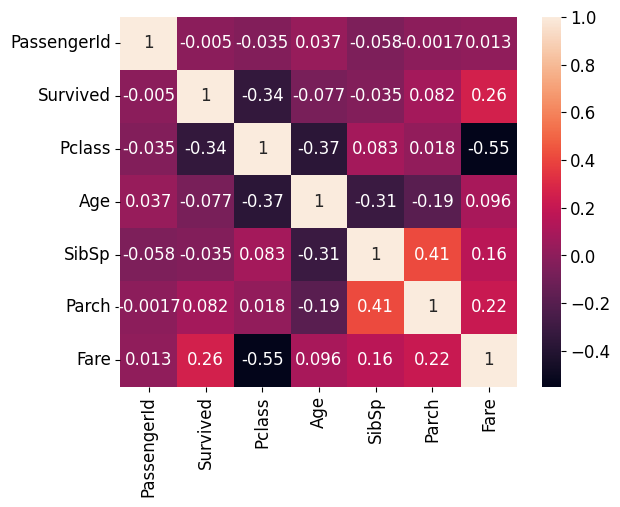

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True)
plt.show()


In order to calculate a correlation matrix, I needed to ignore non-numerical columns.
However, this has some problems. For example,

- It ignores the "Sex" category which our earlier analysis clearly showed to be highly correlated with survival.
- It treats the categorical variable "Pclass" as a continuous variable, likely leading to a misdiagnosis.

To solve for these problems, I'll replace "Sex" and "Pclass" with "Male" and ("Class 1", "Class 2"), respectively. In other words, I'll create one-hot encodings for them.

In [113]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

I'll also want to consider whether Ticket, Cabin, and Embarked are meaningful categories that should be included.